# Simple Convergence Tests for our Random Forest Estimate

In this notebook we will setup the following situation:  
Consider the random variable pair (X, Y). Let $Y \sim Bernoulli(1/2)$ ($Y$ = -1 or 1) and $X \sim \mathcal N(y\mu, 1)$  

We want to show the following using our conditional entropy estimate $\widehat{H(Y|X)}$:  

Given a sample of size n:

1. As $n \rightarrow \infty$, $\widehat{H(Y|X)}$ converges to the true conditional entropy value.
2. As $\mu \rightarrow \infty$, $\widehat{H(Y|X}$ converges to 0.

By showing the two, we can conlude that for this simple case, our estimate converges to the true condititional entropy and is a good estimate of dependence.

## Sampling code

In [3]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

Let's validate that this code is working:

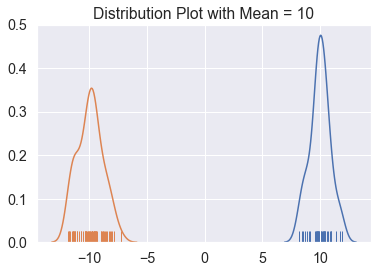

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100, 10, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = 10")
plt.show()

Let's repeat for smaller mean

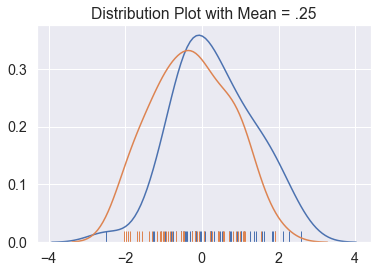

In [4]:
X, y = get_sample(100, .25, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = .25")
plt.show()

Cool, so now we are able to get the sample we want. Now we can perform the two tests we mentioned earlier.

## Test 1: As $n \rightarrow \infty$, does $\widehat{H(Y|X)}$ converge to the true conditional entropy value?


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import entropy

def estimate_conditional_entropy(X, y, n_trees = 10, max_depth = None, bootstrap = False):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = max_depth, random_state = 0)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


For this experiment, we will just be using one version of conditional entropy estimate algorithm. We will use the version where we do not split into training and test and where we do not use bootstrap (sk learn implementation still).  

For this experiment, we will use $\mu = 1$ but this is pretty arbitrary. We will repeat for a couple different means just to make sure we are able to get similar results. We will also be using 10 trees

0.6904028167607392


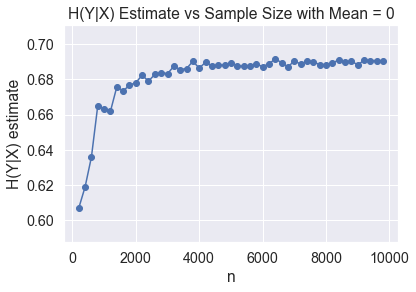

In [8]:
np.warnings.filterwarnings('ignore')

def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(estimate_conditional_entropy(np.array(X).reshape(-1, 1), y, 20, 4, bootstrap = False))
    return sample_sizes, conditional_entropy


sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
plt.plot(sample_sizes, cond_entropy)
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

This converges roughly to the correct value of $H(Y|X)$. We show how we can arrive to this answer below:

$H(Y) = -\frac{1}{2}log(\frac{1}{2}) - \frac{1}{2}log(\frac{1}{2}) = .693147$ (What our estimate converges to roughly)  

$P(X) = P(X|Y = 1)P(Y = 1) + P(X|Y = -1)P(Y = -1)$ by Law of Total Probability  


$H(X) = -\int_x (\frac{1}{2}\mathcal N(\mu, 1) + \frac{1}{2}\mathcal N (-\mu, 1))\log (\frac{1}{2}\mathcal N(\mu, 1) + \frac{1}{2}\mathcal N (-\mu, 1))dx$

Since our mean is 0, this is easy to compute since $-\mu$ and $\mu$ will be the same.  

$H(X) = -\int_x \mathcal N(0, 1) \log (\mathcal N(0, 1))dx = 1.41894$  

Now, we calculate H(X|Y).  

$H(X|Y) = -\sum_y {p(y) H(X|Y = y)} = \frac{1}{2}H(X|y = 1) + \frac{1}{2}H(X|y = -1)$  

Well in our case, the two conditional entropies are the same since we get the same distribution $P(X|Y)$.  

$H(X|Y) = -\int_x \mathcal N(0, 1) \log \mathcal N(0, 1)dx = 1.41894$  

The rest is easy. We now know that $I(X, Y) = H(X) - H(X|Y) = 0$. Therefore, $H(Y) = H(Y|X)$. 

0.351565695552149


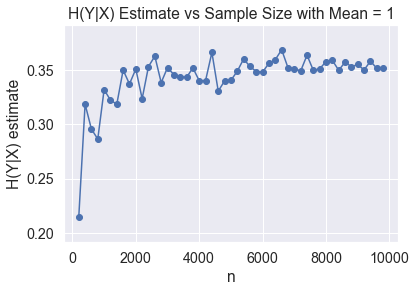

In [10]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
plt.plot(sample_sizes, cond_entropy)
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

We will do the same math as above to calculate the true conditional entropy when $\mu = 1$. The math is actually very clean! $H(Y)$ is still the same.

$H(X) = -\int_x (\frac{1}{2}\mathcal N(1, 1) + \frac{1}{2}\mathcal N(-1, 1))\log (\frac{1}{2}\mathcal N(1, 1) + \frac{1}{2}\mathcal N(-1, 1)) dx$  

This is messy... BUT notice that $\mathcal N(1, 1)$ and $\mathcal N(-1, 1)$ are just mirrors of each other! Besides the different means, the distributions are completely the same. So if we distribute the first summation we should get two identical "entropies"! (I did this numerically in wolfram alpha as well just to make sure).  

$H(X) = -2(\int_x (\frac{1}{2}\mathcal N(1, 1) log (\mathcal N(1, 1))dx = 1.75577$  

Now for $H(X|Y)$ . 

$H(X|Y) = \frac{1}{2} H(X|Y = 1) + \frac{1}{2} H(X| Y = -1)$ . 

Again we use the fact that $H(X|Y = 1) == H(X|Y = -1)$  

So, $H(X|Y) = \int_x \mathcal N(1, 1)\log \mathcal N(1, 1) dx = 1.41894$  

So $I(X, Y) = .33683$. $H(Y|X) = .356316$

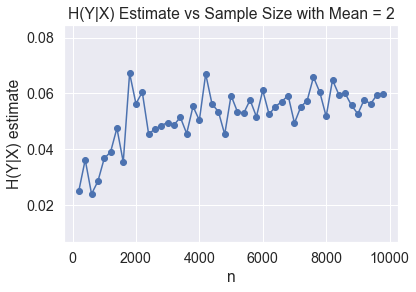

In [48]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(2)
plt.scatter(sample_sizes, cond_entropy)
plt.plot(sample_sizes, cond_entropy)
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 2")
plt.show()

A couple good things. One as our mean increases, we can see conditional entropy estimate converging to a smaller overall value. Also, there is convergence to a value in the first place! However, we had to set the depth of the tree. More experiments are need on how to create a more robust estimate. Example of bad case where we dont limit the depth below (trees grow to 25+ depth)

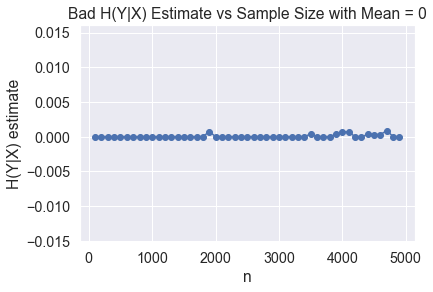

In [44]:
def get_cond_entropy_vs_n_bad(mean):
    conditional_entropy = []
    sample_sizes = [i*100 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(estimate_conditional_entropy(np.array(X).reshape(-1, 1), y, 20, bootstrap = False))
    return sample_sizes, conditional_entropy


sample_sizes, cond_entropy = get_cond_entropy_vs_n_bad(0)
plt.scatter(sample_sizes, cond_entropy)
plt.plot(sample_sizes, cond_entropy)
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.title("Bad H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

## Test 2: as $\mu \rightarrow \infty$, does $\widehat{H(Y|X)}$ converge to 0?

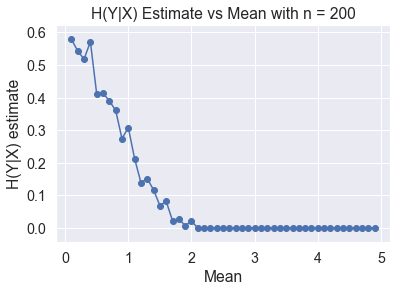

In [50]:
def get_cond_entropy_vs_mu(n):
    conditional_entropy = []
    means = [i*.1 for i in range(1, 50)]
    for elem in means:
        X, y = get_sample(n, elem, 1)
        conditional_entropy.append(estimate_conditional_entropy(np.array(X).reshape(-1, 1), y, 20, 4, bootstrap = False))
    return means, conditional_entropy

means, cond_entropy = get_cond_entropy_vs_mu(200)
plt.scatter(means, cond_entropy)
plt.plot(means, cond_entropy)
plt.xlabel("Mean")
plt.ylabel("H(Y|X) estimate")
plt.title("H(Y|X) Estimate vs Mean with n = 200")
plt.show()

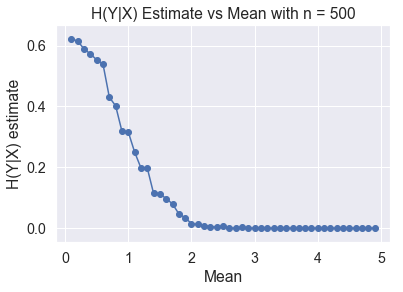

In [51]:
means, cond_entropy = get_cond_entropy_vs_mu(500)
plt.scatter(means, cond_entropy)
plt.plot(means, cond_entropy)
plt.xlabel("Mean")
plt.ylabel("H(Y|X) estimate")
plt.title("H(Y|X) Estimate vs Mean with n = 500")
plt.show()

This is good! It's exactly what we expect to happen. As the two y classes become lineraly separable, the x value contains a lot of information about whether y is 1 or -1. Thus, the conditional entropy of $H(Y|X)$ should be dropping to 0 as expected.